In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1','fe':['b10','b25','b50','b75'],'fi':['roi']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b10_b25_b50_b75_roi_t1_normalized_k5_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 828)
(734160, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:42 - loss: 0.0269 - STD: 1.4761e-04 - MAE: 0.1548

 4/74 [>.............................] - ETA: 1s - loss: 0.0245 - STD: 2.2795e-04 - MAE: 0.1204  

 7/74 [=>............................] - ETA: 1s - loss: 0.0204 - STD: 2.0770e-04 - MAE: 0.1022

10/74 [===>..........................] - ETA: 1s - loss: 0.0194 - STD: 2.0963e-04 - MAE: 0.1060

13/74 [====>.........................] - ETA: 1s - loss: 0.0178 - STD: 2.1203e-04 - MAE: 0.0975

16/74 [=====>........................] - ETA: 1s - loss: 0.0172 - STD: 2.1330e-04 - MAE: 0.0912

19/74 [======>.......................] - ETA: 1s - loss: 0.0164 - STD: 2.2317e-04 - MAE: 0.0868

22/74 [=======>......................] - ETA: 1s - loss: 0.0159 - STD: 2.3995e-04 - MAE: 0.0866

25/74 [=========>....................] - ETA: 1s - loss: 0.0155 - STD: 2.5699e-04 - MAE: 0.0860

28/74 [==========>...................] - ETA: 1s - loss: 0.0151 - STD: 2.7080e-04 - MAE: 0.0835

31/74 [===========>..................] - ETA: 0s - loss: 0.0148 - STD: 2.8480e-04 - MAE: 0.0813

34/74 [============>.................] - ETA: 0s - loss: 0.0146 - STD: 3.0351e-04 - MAE: 0.0802

37/74 [==============>...............] - ETA: 0s - loss: 0.0144 - STD: 3.2506e-04 - MAE: 0.0800

40/74 [===============>..............] - ETA: 0s - loss: 0.0142 - STD: 3.4746e-04 - MAE: 0.0794

43/74 [================>.............] - ETA: 0s - loss: 0.0141 - STD: 3.6995e-04 - MAE: 0.0784

46/74 [=================>............] - ETA: 0s - loss: 0.0139 - STD: 3.9546e-04 - MAE: 0.0776

49/74 [==================>...........] - ETA: 0s - loss: 0.0138 - STD: 4.2571e-04 - MAE: 0.0773

52/74 [====================>.........] - ETA: 0s - loss: 0.0137 - STD: 4.5883e-04 - MAE: 0.0770

55/74 [=====================>........] - ETA: 0s - loss: 0.0136 - STD: 4.9441e-04 - MAE: 0.0764

58/74 [======================>.......] - ETA: 0s - loss: 0.0135 - STD: 5.3451e-04 - MAE: 0.0759

61/74 [=======================>......] - ETA: 0s - loss: 0.0135 - STD: 5.8276e-04 - MAE: 0.0756

64/74 [========================>.....] - ETA: 0s - loss: 0.0134 - STD: 6.3885e-04 - MAE: 0.0755

67/74 [==========================>...] - ETA: 0s - loss: 0.0133 - STD: 7.0115e-04 - MAE: 0.0751

70/74 [===========================>..] - ETA: 0s - loss: 0.0132 - STD: 7.7331e-04 - MAE: 0.0747

73/74 [============================>.] - ETA: 0s - loss: 0.0132 - STD: 8.5976e-04 - MAE: 0.0744

74/74 [==============================] - 5s 43ms/step - loss: 0.0131 - STD: 8.9334e-04 - MAE: 0.0744 - val_loss: 0.0139 - val_STD: 0.0029 - val_MAE: 0.0746


Epoch 2/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0116 - STD: 0.0036 - MAE: 0.0705

 4/74 [>.............................] - ETA: 1s - loss: 0.0114 - STD: 0.0039 - MAE: 0.0686

 7/74 [=>............................] - ETA: 1s - loss: 0.0114 - STD: 0.0044 - MAE: 0.0677

10/74 [===>..........................] - ETA: 1s - loss: 0.0112 - STD: 0.0049 - MAE: 0.0673

13/74 [====>.........................] - ETA: 1s - loss: 0.0111 - STD: 0.0056 - MAE: 0.0668

16/74 [=====>........................] - ETA: 1s - loss: 0.0110 - STD: 0.0065 - MAE: 0.0665

19/74 [======>.......................] - ETA: 1s - loss: 0.0108 - STD: 0.0077 - MAE: 0.0662

22/74 [=======>......................] - ETA: 1s - loss: 0.0106 - STD: 0.0091 - MAE: 0.0655

25/74 [=========>....................] - ETA: 1s - loss: 0.0104 - STD: 0.0111 - MAE: 0.0648

28/74 [==========>...................] - ETA: 1s - loss: 0.0101 - STD: 0.0137 - MAE: 0.0636

31/74 [===========>..................] - ETA: 0s - loss: 0.0097 - STD: 0.0170 - MAE: 0.0625

34/74 [============>.................] - ETA: 0s - loss: 0.0093 - STD: 0.0211 - MAE: 0.0611

37/74 [==============>...............] - ETA: 0s - loss: 0.0089 - STD: 0.0257 - MAE: 0.0598

40/74 [===============>..............] - ETA: 0s - loss: 0.0086 - STD: 0.0306 - MAE: 0.0587

43/74 [================>.............] - ETA: 0s - loss: 0.0083 - STD: 0.0350 - MAE: 0.0576

46/74 [=================>............] - ETA: 0s - loss: 0.0081 - STD: 0.0385 - MAE: 0.0565

49/74 [==================>...........] - ETA: 0s - loss: 0.0078 - STD: 0.0412 - MAE: 0.0555

52/74 [====================>.........] - ETA: 0s - loss: 0.0076 - STD: 0.0439 - MAE: 0.0546

55/74 [=====================>........] - ETA: 0s - loss: 0.0074 - STD: 0.0467 - MAE: 0.0538

58/74 [======================>.......] - ETA: 0s - loss: 0.0072 - STD: 0.0492 - MAE: 0.0530

61/74 [=======================>......] - ETA: 0s - loss: 0.0070 - STD: 0.0513 - MAE: 0.0523

64/74 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0531 - MAE: 0.0516

67/74 [==========================>...] - ETA: 0s - loss: 0.0067 - STD: 0.0548 - MAE: 0.0511

70/74 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0565 - MAE: 0.0505

73/74 [============================>.] - ETA: 0s - loss: 0.0064 - STD: 0.0580 - MAE: 0.0499

74/74 [==============================] - 2s 25ms/step - loss: 0.0064 - STD: 0.0585 - MAE: 0.0498 - val_loss: 0.0037 - val_STD: 0.0729 - val_MAE: 0.0374


Epoch 3/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0917 - MAE: 0.0369

 4/74 [>.............................] - ETA: 1s - loss: 0.0033 - STD: 0.0914 - MAE: 0.0369

 7/74 [=>............................] - ETA: 1s - loss: 0.0033 - STD: 0.0911 - MAE: 0.0368

10/74 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0915 - MAE: 0.0365

13/74 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.0919 - MAE: 0.0364

16/74 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0924 - MAE: 0.0363

19/74 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0925 - MAE: 0.0362

22/74 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0924 - MAE: 0.0361

25/74 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0923 - MAE: 0.0359

28/74 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0925 - MAE: 0.0358

31/74 [===========>..................] - ETA: 0s - loss: 0.0031 - STD: 0.0926 - MAE: 0.0356

34/74 [============>.................] - ETA: 0s - loss: 0.0030 - STD: 0.0929 - MAE: 0.0355

37/74 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0931 - MAE: 0.0354

40/74 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.0931 - MAE: 0.0355

43/74 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0932 - MAE: 0.0356

46/74 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0934 - MAE: 0.0355

49/74 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0935 - MAE: 0.0354

52/74 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0936 - MAE: 0.0353

55/74 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0938 - MAE: 0.0352

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0939 - MAE: 0.0351

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0940 - MAE: 0.0350

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0940 - MAE: 0.0349

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0941 - MAE: 0.0349

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0943 - MAE: 0.0348

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0944 - MAE: 0.0347

74/74 [==============================] - 2s 26ms/step - loss: 0.0029 - STD: 0.0945 - MAE: 0.0347 - val_loss: 0.0030 - val_STD: 0.0768 - val_MAE: 0.0337


Epoch 4/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0025 - STD: 0.0974 - MAE: 0.0327

 4/74 [>.............................] - ETA: 1s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0331

 7/74 [=>............................] - ETA: 1s - loss: 0.0026 - STD: 0.0968 - MAE: 0.0331

10/74 [===>..........................] - ETA: 1s - loss: 0.0026 - STD: 0.0966 - MAE: 0.0330

13/74 [====>.........................] - ETA: 1s - loss: 0.0026 - STD: 0.0962 - MAE: 0.0333

16/74 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0332

19/74 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.0964 - MAE: 0.0333

22/74 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0961 - MAE: 0.0334

25/74 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.0961 - MAE: 0.0334

28/74 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.0961 - MAE: 0.0334

31/74 [===========>..................] - ETA: 0s - loss: 0.0026 - STD: 0.0962 - MAE: 0.0334

34/74 [============>.................] - ETA: 0s - loss: 0.0026 - STD: 0.0961 - MAE: 0.0333

37/74 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.0962 - MAE: 0.0332

40/74 [===============>..............] - ETA: 0s - loss: 0.0026 - STD: 0.0964 - MAE: 0.0331

43/74 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.0964 - MAE: 0.0331

46/74 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.0965 - MAE: 0.0331

49/74 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0331

52/74 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0330

55/74 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0330

58/74 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0330

61/74 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0329

64/74 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0330

66/74 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0330

68/74 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0330

71/74 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0329

74/74 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0329

74/74 [==============================] - 2s 26ms/step - loss: 0.0025 - STD: 0.0968 - MAE: 0.0329 - val_loss: 0.0029 - val_STD: 0.0770 - val_MAE: 0.0332


Epoch 5/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0024 - STD: 0.0985 - MAE: 0.0324

 4/74 [>.............................] - ETA: 1s - loss: 0.0024 - STD: 0.0986 - MAE: 0.0323

 7/74 [=>............................] - ETA: 1s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0325

10/74 [===>..........................] - ETA: 1s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0325

13/74 [====>.........................] - ETA: 1s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0325

16/74 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.0971 - MAE: 0.0335

19/74 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.0971 - MAE: 0.0337

22/74 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0971 - MAE: 0.0337

25/74 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.0971 - MAE: 0.0335

28/74 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.0971 - MAE: 0.0333

31/74 [===========>..................] - ETA: 0s - loss: 0.0025 - STD: 0.0971 - MAE: 0.0332

34/74 [============>.................] - ETA: 0s - loss: 0.0025 - STD: 0.0971 - MAE: 0.0331

37/74 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.0973 - MAE: 0.0330

40/74 [===============>..............] - ETA: 0s - loss: 0.0025 - STD: 0.0974 - MAE: 0.0329

43/74 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.0974 - MAE: 0.0329

46/74 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.0974 - MAE: 0.0329

49/74 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.0973 - MAE: 0.0328

52/74 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.0973 - MAE: 0.0328

55/74 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0974 - MAE: 0.0328

58/74 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0975 - MAE: 0.0328

61/74 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0975 - MAE: 0.0327

64/74 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0975 - MAE: 0.0327

67/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0327

70/74 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0327

73/74 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0327

74/74 [==============================] - 2s 26ms/step - loss: 0.0024 - STD: 0.0975 - MAE: 0.0326 - val_loss: 0.0028 - val_STD: 0.0765 - val_MAE: 0.0331


Epoch 6/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0023 - STD: 0.0958 - MAE: 0.0314

 4/74 [>.............................] - ETA: 1s - loss: 0.0023 - STD: 0.0970 - MAE: 0.0319

 7/74 [=>............................] - ETA: 1s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0323

10/74 [===>..........................] - ETA: 1s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0323

13/74 [====>.........................] - ETA: 1s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0322

16/74 [=====>........................] - ETA: 1s - loss: 0.0024 - STD: 0.0970 - MAE: 0.0323

19/74 [======>.......................] - ETA: 1s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0323

22/74 [=======>......................] - ETA: 1s - loss: 0.0024 - STD: 0.0974 - MAE: 0.0324

25/74 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0324

28/74 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0324

31/74 [===========>..................] - ETA: 0s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0323

34/74 [============>.................] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0323

37/74 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0323

40/74 [===============>..............] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0323

43/74 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0323

46/74 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0325

49/74 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0325

52/74 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0324

55/74 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0325

58/74 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0324

61/74 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0324

64/74 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0324

67/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0323

70/74 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0323

73/74 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0323

74/74 [==============================] - 2s 26ms/step - loss: 0.0024 - STD: 0.0978 - MAE: 0.0323 - val_loss: 0.0028 - val_STD: 0.0750 - val_MAE: 0.0330


Epoch 7/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0022 - STD: 0.0947 - MAE: 0.0305

 4/74 [>.............................] - ETA: 1s - loss: 0.0024 - STD: 0.0965 - MAE: 0.0319

 7/74 [=>............................] - ETA: 1s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0319

10/74 [===>..........................] - ETA: 1s - loss: 0.0024 - STD: 0.0982 - MAE: 0.0320

13/74 [====>.........................] - ETA: 1s - loss: 0.0024 - STD: 0.0981 - MAE: 0.0323

16/74 [=====>........................] - ETA: 1s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0322

19/74 [======>.......................] - ETA: 1s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0322

22/74 [=======>......................] - ETA: 1s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0322

25/74 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0322

28/74 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0322

31/74 [===========>..................] - ETA: 0s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0323

34/74 [============>.................] - ETA: 0s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0325

37/74 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0324

40/74 [===============>..............] - ETA: 0s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0324

43/74 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0324

46/74 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0324

48/74 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0323

51/74 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0323

54/74 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0323

57/74 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0323

60/74 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0323

63/74 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0322

66/74 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0322

69/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0322

72/74 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0322

74/74 [==============================] - 2s 26ms/step - loss: 0.0024 - STD: 0.0980 - MAE: 0.0322 - val_loss: 0.0028 - val_STD: 0.0751 - val_MAE: 0.0329


Epoch 8/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0310

 4/74 [>.............................] - ETA: 1s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0316

 7/74 [=>............................] - ETA: 1s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0317

10/74 [===>..........................] - ETA: 1s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0317

13/74 [====>.........................] - ETA: 1s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0318

16/74 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0318

19/74 [======>.......................] - ETA: 1s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0318

22/74 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0318

25/74 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0319

28/74 [==========>...................] - ETA: 1s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0319

30/74 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0319

32/74 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0320

35/74 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0320

38/74 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0320

40/74 [===============>..............] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0320

43/74 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0321

46/74 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0321

49/74 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0322

52/74 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0322

55/74 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0322

58/74 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0322

61/74 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0322

64/74 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0323

67/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0324

70/74 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0325

73/74 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0325

74/74 [==============================] - 2s 27ms/step - loss: 0.0024 - STD: 0.0978 - MAE: 0.0327 - val_loss: 0.0041 - val_STD: 0.0674 - val_MAE: 0.0416


Epoch 9/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.0887 - MAE: 0.0393

 3/74 [>.............................] - ETA: 1s - loss: 0.0033 - STD: 0.0960 - MAE: 0.0407

 6/74 [=>............................] - ETA: 1s - loss: 0.0034 - STD: 0.0945 - MAE: 0.0413

 9/74 [==>...........................] - ETA: 1s - loss: 0.0032 - STD: 0.0941 - MAE: 0.0390

12/74 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0386

15/74 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0945 - MAE: 0.0380

17/74 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0948 - MAE: 0.0376

20/74 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0950 - MAE: 0.0368

23/74 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0953 - MAE: 0.0363

26/74 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0958 - MAE: 0.0359

29/74 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0960 - MAE: 0.0355

32/74 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.0961 - MAE: 0.0352

35/74 [=============>................] - ETA: 0s - loss: 0.0027 - STD: 0.0963 - MAE: 0.0350

38/74 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.0964 - MAE: 0.0348

41/74 [===============>..............] - ETA: 0s - loss: 0.0027 - STD: 0.0964 - MAE: 0.0345

44/74 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.0964 - MAE: 0.0343

47/74 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.0966 - MAE: 0.0341

50/74 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.0967 - MAE: 0.0339

53/74 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.0967 - MAE: 0.0338

56/74 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.0968 - MAE: 0.0337

59/74 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0969 - MAE: 0.0336

61/74 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0335

64/74 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0334

67/74 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0333

70/74 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0332

73/74 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0332

74/74 [==============================] - 2s 27ms/step - loss: 0.0025 - STD: 0.0970 - MAE: 0.0331 - val_loss: 0.0027 - val_STD: 0.0767 - val_MAE: 0.0327


Epoch 10/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0023 - STD: 0.0994 - MAE: 0.0319

 3/74 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0312

 6/74 [=>............................] - ETA: 1s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0317

 9/74 [==>...........................] - ETA: 1s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0318

12/74 [===>..........................] - ETA: 1s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0318

15/74 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0318

18/74 [======>.......................] - ETA: 1s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0318

21/74 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0317

24/74 [========>.....................] - ETA: 1s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0317

27/74 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0317

30/74 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0317

33/74 [============>.................] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0317

36/74 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0317

38/74 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0317

40/74 [===============>..............] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0317

42/74 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0317

44/74 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0316

47/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0316

50/74 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0316

53/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0316

56/74 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0316

59/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0316

62/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0316

65/74 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0316

68/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0316

71/74 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0316

74/74 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0316

74/74 [==============================] - 2s 27ms/step - loss: 0.0023 - STD: 0.0983 - MAE: 0.0316 - val_loss: 0.0027 - val_STD: 0.0760 - val_MAE: 0.0326


Epoch 11/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0309

 4/74 [>.............................] - ETA: 1s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0315

 7/74 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.0974 - MAE: 0.0315

10/74 [===>..........................] - ETA: 1s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0315

13/74 [====>.........................] - ETA: 1s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0315

16/74 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0315

19/74 [======>.......................] - ETA: 1s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0315

22/74 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0315

25/74 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0315

28/74 [==========>...................] - ETA: 1s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0315

31/74 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0315

33/74 [============>.................] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0316

35/74 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0315

38/74 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0315

41/74 [===============>..............] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0315

44/74 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0315

47/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0315

49/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0315

51/74 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0316

53/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0316

56/74 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0316

58/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0316

60/74 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0317

63/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0317

66/74 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0316

68/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0316

71/74 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0316

74/74 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0316

74/74 [==============================] - 2s 28ms/step - loss: 0.0023 - STD: 0.0984 - MAE: 0.0316 - val_loss: 0.0027 - val_STD: 0.0764 - val_MAE: 0.0325


Epoch 12/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0318

 3/74 [>.............................] - ETA: 1s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0317

 5/74 [=>............................] - ETA: 1s - loss: 0.0023 - STD: 0.0995 - MAE: 0.0319

 8/74 [==>...........................] - ETA: 1s - loss: 0.0023 - STD: 0.0997 - MAE: 0.0321

10/74 [===>..........................] - ETA: 1s - loss: 0.0023 - STD: 0.0992 - MAE: 0.0322

13/74 [====>.........................] - ETA: 1s - loss: 0.0024 - STD: 0.0987 - MAE: 0.0323

16/74 [=====>........................] - ETA: 1s - loss: 0.0024 - STD: 0.0988 - MAE: 0.0325

19/74 [======>.......................] - ETA: 1s - loss: 0.0024 - STD: 0.0988 - MAE: 0.0326

22/74 [=======>......................] - ETA: 1s - loss: 0.0024 - STD: 0.0985 - MAE: 0.0326

25/74 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.0983 - MAE: 0.0326

28/74 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.0983 - MAE: 0.0326

31/74 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.0983 - MAE: 0.0325

34/74 [============>.................] - ETA: 0s - loss: 0.0024 - STD: 0.0982 - MAE: 0.0325

36/74 [=============>................] - ETA: 0s - loss: 0.0024 - STD: 0.0983 - MAE: 0.0325

39/74 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.0983 - MAE: 0.0324

42/74 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.0982 - MAE: 0.0323

45/74 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.0981 - MAE: 0.0323

47/74 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0323

50/74 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0323

53/74 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0323

56/74 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0322

59/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0322

62/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0321

65/74 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0321

68/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0321

71/74 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0320

74/74 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0320

74/74 [==============================] - 2s 27ms/step - loss: 0.0023 - STD: 0.0982 - MAE: 0.0320 - val_loss: 0.0027 - val_STD: 0.0755 - val_MAE: 0.0324


Epoch 13/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0314

 3/74 [>.............................] - ETA: 1s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0315

 5/74 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0312

 8/74 [==>...........................] - ETA: 1s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0313

11/74 [===>..........................] - ETA: 1s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0313

14/74 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0313

17/74 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0313

19/74 [======>.......................] - ETA: 1s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0314

22/74 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0314

25/74 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0315

28/74 [==========>...................] - ETA: 1s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0316

31/74 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0318

34/74 [============>.................] - ETA: 0s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0319

37/74 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0320

39/74 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0320

41/74 [===============>..............] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0320

43/74 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0320

46/74 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0320

49/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0320

52/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0321

55/74 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0321

58/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0321

61/74 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0320

64/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0320

67/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0320

70/74 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0319

73/74 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0319

74/74 [==============================] - 2s 27ms/step - loss: 0.0023 - STD: 0.0983 - MAE: 0.0319 - val_loss: 0.0028 - val_STD: 0.0739 - val_MAE: 0.0326


Epoch 14/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0319

 3/74 [>.............................] - ETA: 1s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0317

 6/74 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.0975 - MAE: 0.0313

 9/74 [==>...........................] - ETA: 1s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0311

12/74 [===>..........................] - ETA: 1s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0311

15/74 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0311

17/74 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0312

20/74 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0312

23/74 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0312

26/74 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0312

29/74 [==========>...................] - ETA: 1s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0313

32/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0313

35/74 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0312

38/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0312

41/74 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0313

44/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0313

47/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0314

50/74 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0314

53/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0314

56/74 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0314

59/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0314

62/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0314

65/74 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0314

68/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0314

71/74 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0314

74/74 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0314

74/74 [==============================] - 2s 28ms/step - loss: 0.0023 - STD: 0.0985 - MAE: 0.0314 - val_loss: 0.0027 - val_STD: 0.0755 - val_MAE: 0.0322


Epoch 15/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0022 - STD: 0.0957 - MAE: 0.0313

 3/74 [>.............................] - ETA: 1s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0314

 6/74 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0313

 9/74 [==>...........................] - ETA: 1s - loss: 0.0023 - STD: 0.0990 - MAE: 0.0313

12/74 [===>..........................] - ETA: 1s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0313

15/74 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0312

18/74 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0313

21/74 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0313

24/74 [========>.....................] - ETA: 1s - loss: 0.0023 - STD: 0.0993 - MAE: 0.0314

27/74 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0992 - MAE: 0.0315

30/74 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0991 - MAE: 0.0315

33/74 [============>.................] - ETA: 0s - loss: 0.0023 - STD: 0.0990 - MAE: 0.0315

36/74 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0315

39/74 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0315

42/74 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0990 - MAE: 0.0315

44/74 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0990 - MAE: 0.0315

47/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0315

49/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0315

52/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0315

55/74 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0315

57/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0315

59/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0315

62/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0315

65/74 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0315

68/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0315

71/74 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0314

74/74 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0314

74/74 [==============================] - 2s 27ms/step - loss: 0.0023 - STD: 0.0987 - MAE: 0.0314 - val_loss: 0.0026 - val_STD: 0.0756 - val_MAE: 0.0323


Epoch 16/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0315

 3/74 [>.............................] - ETA: 1s - loss: 0.0022 - STD: 0.0968 - MAE: 0.0313

 6/74 [=>............................] - ETA: 1s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0315

 9/74 [==>...........................] - ETA: 1s - loss: 0.0023 - STD: 0.0990 - MAE: 0.0315

12/74 [===>..........................] - ETA: 1s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0314

15/74 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.0990 - MAE: 0.0314

18/74 [======>.......................] - ETA: 1s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0314

21/74 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0313

24/74 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0313

27/74 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0313

29/74 [==========>...................] - ETA: 1s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0313

31/74 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0313

34/74 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0313

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0313

40/74 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0314

43/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0314

46/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0314

49/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0314

52/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0990 - MAE: 0.0314

55/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0314

58/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0314

61/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0313

64/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0313

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0313

70/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0313

73/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0313

74/74 [==============================] - 2s 27ms/step - loss: 0.0022 - STD: 0.0988 - MAE: 0.0313 - val_loss: 0.0027 - val_STD: 0.0742 - val_MAE: 0.0321


Epoch 17/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.0975 - MAE: 0.0305

 4/74 [>.............................] - ETA: 1s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0312

 7/74 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0312

10/74 [===>..........................] - ETA: 1s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0313

12/74 [===>..........................] - ETA: 1s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0312

15/74 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0312

18/74 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0312

21/74 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0312

24/74 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0313

27/74 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0312

29/74 [==========>...................] - ETA: 1s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0312

31/74 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0313

34/74 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0313

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0313

39/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0313

42/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0313

45/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0313

48/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0313

51/74 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0313

54/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0313

57/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0313

60/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0313

63/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0314

66/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0314

69/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0314

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0313

74/74 [==============================] - 2s 27ms/step - loss: 0.0022 - STD: 0.0988 - MAE: 0.0313 - val_loss: 0.0026 - val_STD: 0.0760 - val_MAE: 0.0321


Epoch 18/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.1012 - MAE: 0.0317

 4/74 [>.............................] - ETA: 1s - loss: 0.0023 - STD: 0.0994 - MAE: 0.0314

 7/74 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0312

10/74 [===>..........................] - ETA: 1s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0312

13/74 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0312

15/74 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0312

17/74 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0313

19/74 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0314

21/74 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0313

24/74 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0314

27/74 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0314

30/74 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0314

33/74 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0314

36/74 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0314

39/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0314

42/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0314

44/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0314

46/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0314

49/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0314

52/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0313

55/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0313

58/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0313

61/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0313

64/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0313

66/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0313

69/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0313

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0313

74/74 [==============================] - 2s 27ms/step - loss: 0.0022 - STD: 0.0989 - MAE: 0.0313 - val_loss: 0.0028 - val_STD: 0.0724 - val_MAE: 0.0323


Epoch 19/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.0971 - MAE: 0.0308

 4/74 [>.............................] - ETA: 1s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0314

 6/74 [=>............................] - ETA: 1s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0316

 8/74 [==>...........................] - ETA: 1s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0316

11/74 [===>..........................] - ETA: 1s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0317

14/74 [====>.........................] - ETA: 1s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0318

17/74 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0320

20/74 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0321

23/74 [========>.....................] - ETA: 1s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0320

26/74 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0320

29/74 [==========>...................] - ETA: 1s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0319

32/74 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0319

35/74 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0319

38/74 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0318

41/74 [===============>..............] - ETA: 0s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0319

44/74 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0319

46/74 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0318

49/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0318

52/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0317

54/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0317

57/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0317

59/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0316

62/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0316

65/74 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0316

68/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0316

71/74 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0315

74/74 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0315

74/74 [==============================] - 2s 27ms/step - loss: 0.0023 - STD: 0.0986 - MAE: 0.0315 - val_loss: 0.0026 - val_STD: 0.0758 - val_MAE: 0.0321


Epoch 20/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.1002 - MAE: 0.0312

 3/74 [>.............................] - ETA: 1s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0310

 6/74 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0312

 9/74 [==>...........................] - ETA: 1s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0312

12/74 [===>..........................] - ETA: 1s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0313

15/74 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0994 - MAE: 0.0313

18/74 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.0994 - MAE: 0.0312

21/74 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0996 - MAE: 0.0312

24/74 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.0996 - MAE: 0.0312

27/74 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0312

30/74 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0312

33/74 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.0995 - MAE: 0.0312

35/74 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.0995 - MAE: 0.0312

38/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0312

41/74 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0312

43/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0311

45/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0312

48/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0312

51/74 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0312

54/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0312

57/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0312

60/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0312

63/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0312

66/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0312

69/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0312

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0312

74/74 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0312

74/74 [==============================] - 2s 27ms/step - loss: 0.0022 - STD: 0.0988 - MAE: 0.0312 - val_loss: 0.0027 - val_STD: 0.0723 - val_MAE: 0.0321


Epoch 21/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.0962 - MAE: 0.0309

 4/74 [>.............................] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0313

 7/74 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.0997 - MAE: 0.0315

10/74 [===>..........................] - ETA: 1s - loss: 0.0023 - STD: 0.0994 - MAE: 0.0316

13/74 [====>.........................] - ETA: 1s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0317

16/74 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.0991 - MAE: 0.0316

19/74 [======>.......................] - ETA: 1s - loss: 0.0023 - STD: 0.0992 - MAE: 0.0317

21/74 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.0991 - MAE: 0.0316

24/74 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0316

27/74 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0316

29/74 [==========>...................] - ETA: 1s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0316

32/74 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0316

35/74 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0315

38/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0315

41/74 [===============>..............] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0314

44/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0314

46/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0314

49/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0314

52/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0314

55/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0314

58/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0314

60/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0315

62/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0315

64/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0315

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0315

70/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0314

73/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0314

74/74 [==============================] - 2s 27ms/step - loss: 0.0022 - STD: 0.0988 - MAE: 0.0314 - val_loss: 0.0026 - val_STD: 0.0737 - val_MAE: 0.0329


Epoch 22/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0020 - STD: 0.0971 - MAE: 0.0305

 3/74 [>.............................] - ETA: 1s - loss: 0.0021 - STD: 0.0961 - MAE: 0.0304

 6/74 [=>............................] - ETA: 1s - loss: 0.0021 - STD: 0.0978 - MAE: 0.0307

 9/74 [==>...........................] - ETA: 1s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0309

12/74 [===>..........................] - ETA: 1s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0308

15/74 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0309

18/74 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0310

21/74 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0310

24/74 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0310

27/74 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0310

30/74 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0311

33/74 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0311

35/74 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0311

38/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0311

41/74 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0311

44/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0311

47/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0311

50/74 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0311

53/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0312

56/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0312

58/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0313

61/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0313

64/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0313

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0313

70/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0313

73/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0313

74/74 [==============================] - 2s 27ms/step - loss: 0.0022 - STD: 0.0988 - MAE: 0.0312 - val_loss: 0.0026 - val_STD: 0.0738 - val_MAE: 0.0319


Epoch 23/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0022 - STD: 0.0950 - MAE: 0.0302

 4/74 [>.............................] - ETA: 1s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0309

 7/74 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0309

10/74 [===>..........................] - ETA: 1s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0310

13/74 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0311

16/74 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0310

18/74 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0310

21/74 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0310

24/74 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0310

27/74 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0311

30/74 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0311

33/74 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0312

36/74 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0312

39/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0312

42/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0312

45/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0312

48/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0312

51/74 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0311

54/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0312

57/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0312

60/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0312

63/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0312

65/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0312

68/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0312

71/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0312

73/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0312

74/74 [==============================] - 2s 27ms/step - loss: 0.0022 - STD: 0.0988 - MAE: 0.0312 - val_loss: 0.0026 - val_STD: 0.0735 - val_MAE: 0.0319


Epoch 24/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.0958 - MAE: 0.0303

 3/74 [>.............................] - ETA: 1s - loss: 0.0022 - STD: 0.0994 - MAE: 0.0307

 6/74 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0309

 9/74 [==>...........................] - ETA: 1s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0308

11/74 [===>..........................] - ETA: 1s - loss: 0.0022 - STD: 0.0996 - MAE: 0.0307

13/74 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0308

16/74 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0308

19/74 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0309

22/74 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0310

25/74 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0311

28/74 [==========>...................] - ETA: 1s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0311

31/74 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0310

34/74 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0309

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0310

40/74 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0309

43/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0310

46/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0310

49/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0310

52/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0310

54/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0310

56/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0310

59/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0310

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0309

64/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0309

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0309

69/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0309

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0310

74/74 [==============================] - 2s 27ms/step - loss: 0.0022 - STD: 0.0990 - MAE: 0.0310 - val_loss: 0.0029 - val_STD: 0.0698 - val_MAE: 0.0330


Epoch 25/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0903 - MAE: 0.0309

 3/74 [>.............................] - ETA: 1s - loss: 0.0022 - STD: 0.0954 - MAE: 0.0311

 6/74 [=>............................] - ETA: 1s - loss: 0.0023 - STD: 0.0968 - MAE: 0.0315

 8/74 [==>...........................] - ETA: 1s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0317

10/74 [===>..........................] - ETA: 1s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0317

13/74 [====>.........................] - ETA: 1s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0317

15/74 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0315

18/74 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0314

21/74 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0313

23/74 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0312

26/74 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0312

29/74 [==========>...................] - ETA: 1s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0312

32/74 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0311

35/74 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0311

38/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0311

41/74 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0311

44/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0311

47/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0311

50/74 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0311

52/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0311

55/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0310

58/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0310

60/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0310

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0310

64/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0310

66/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0310

69/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0310

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0310

74/74 [==============================] - 2s 28ms/step - loss: 0.0022 - STD: 0.0989 - MAE: 0.0310 - val_loss: 0.0027 - val_STD: 0.0723 - val_MAE: 0.0323


Epoch 26/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0304

 4/74 [>.............................] - ETA: 1s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0308

 7/74 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0308

10/74 [===>..........................] - ETA: 1s - loss: 0.0022 - STD: 0.0996 - MAE: 0.0307

13/74 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.0994 - MAE: 0.0308

16/74 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0308

19/74 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.0994 - MAE: 0.0308

22/74 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0308

25/74 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0308

27/74 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0308

30/74 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0309

32/74 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0309

34/74 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0309

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0310

40/74 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0310

43/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0311

46/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0310

49/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0310

52/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0310

54/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0310

56/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0310

58/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0310

61/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0310

64/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0309

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0310

70/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0310

73/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0309

74/74 [==============================] - 2s 27ms/step - loss: 0.0022 - STD: 0.0990 - MAE: 0.0309 - val_loss: 0.0027 - val_STD: 0.0724 - val_MAE: 0.0323


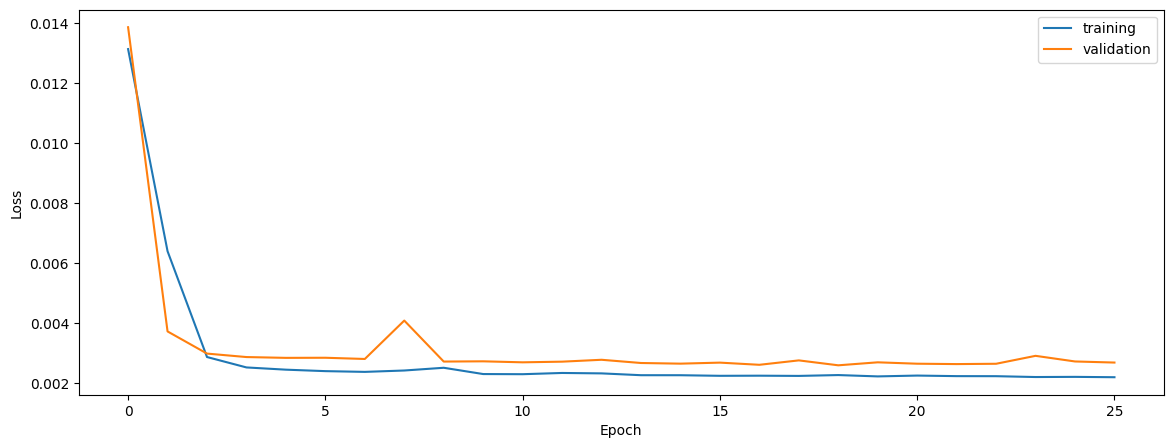

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.90381516974833
0.9081050616817633
0.8938724522371656


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

normalized
0.8951218937442537
0.917351848885612
0.9142767063620494


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.9036575915876838
0.9252386518062131
0.9290776437138558


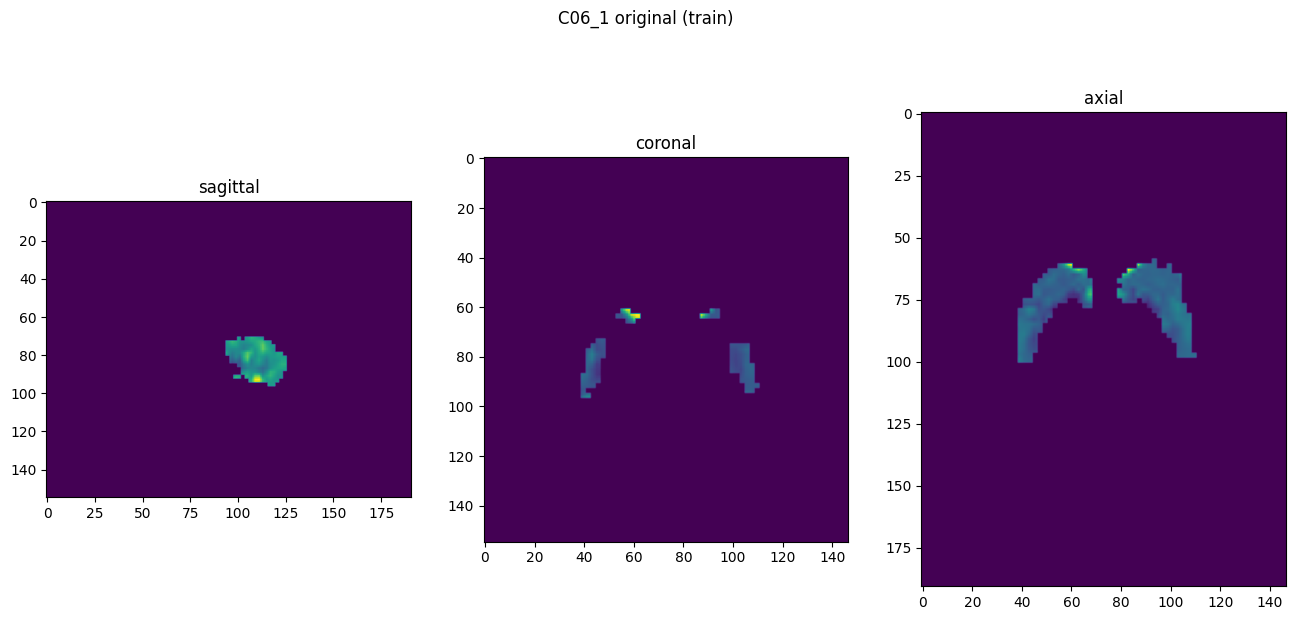

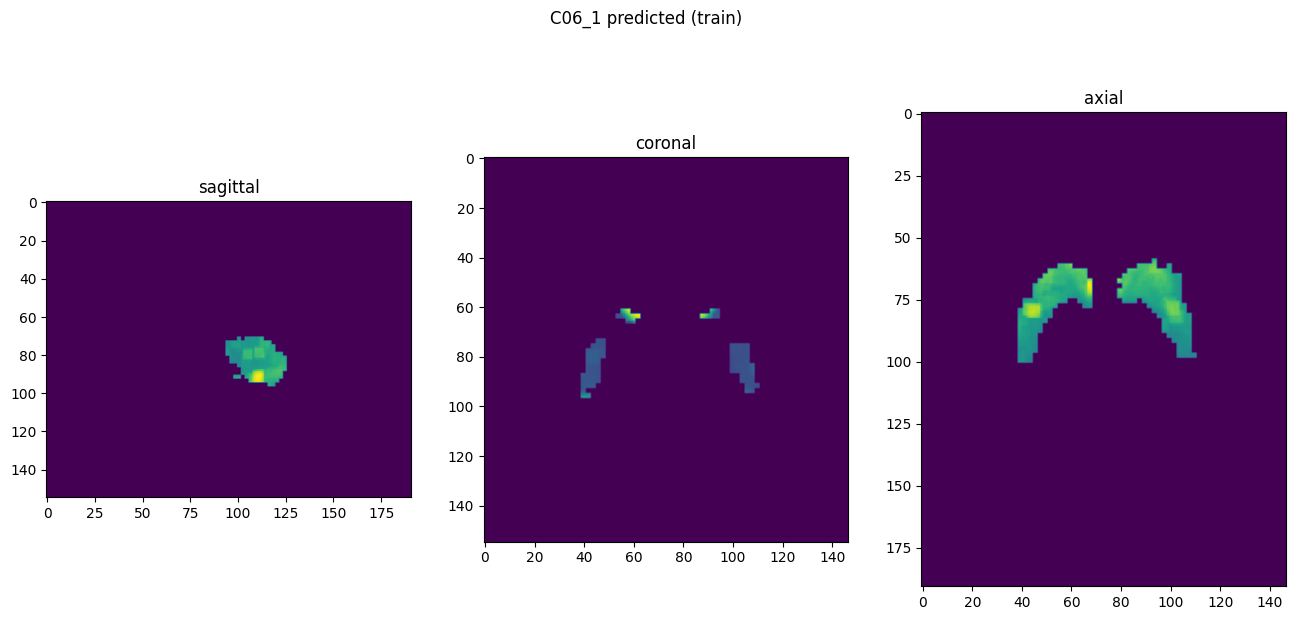

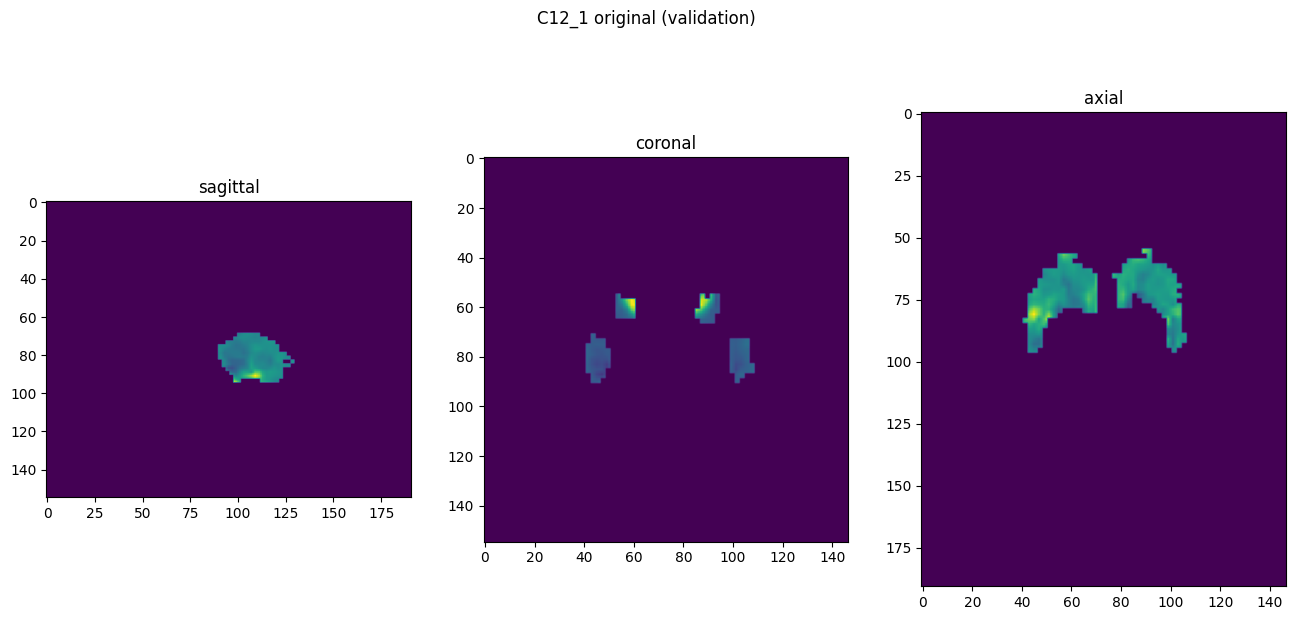

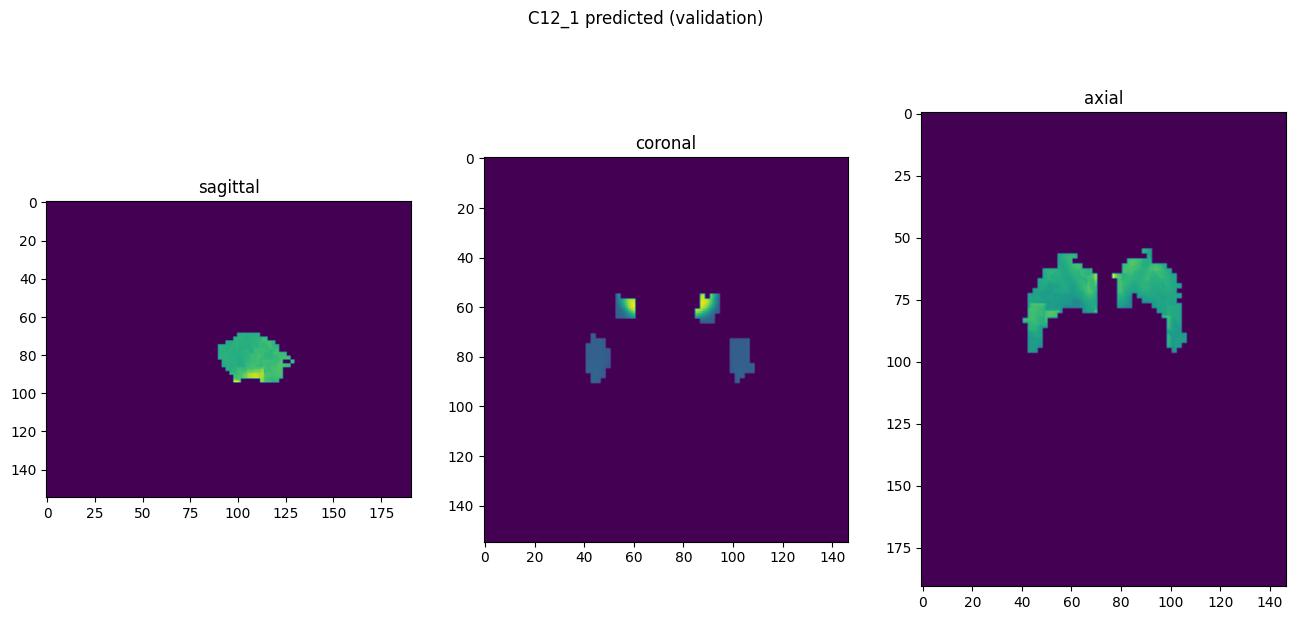

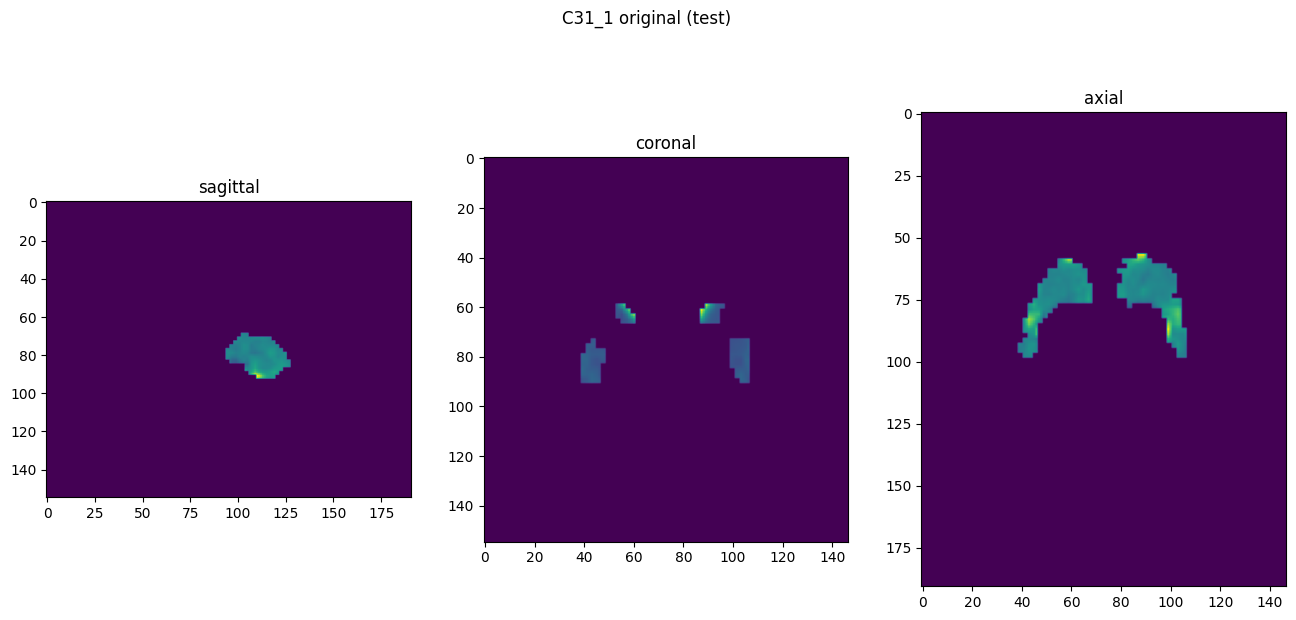

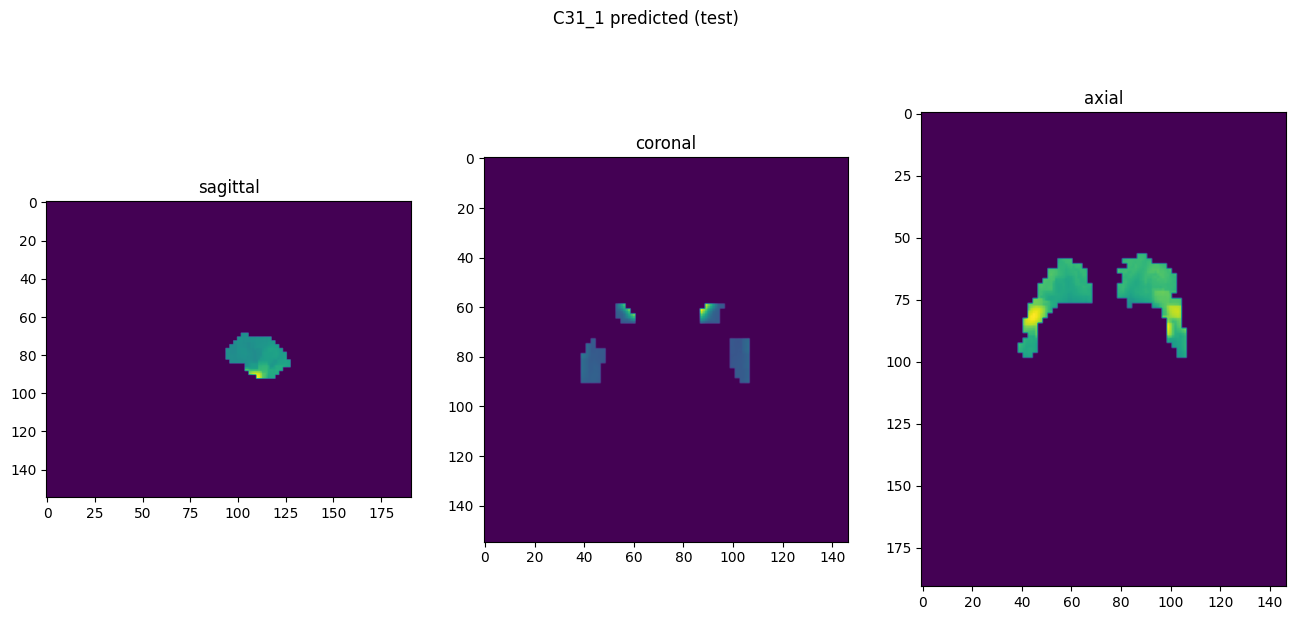

In [10]:
showResults(model, gen, threshold=None, background=False)